# **2. Modelos de Suavização Exponencial**
---

Neste capítulo, você irá aprender:

1. O uso dos modelos de Suavização Exponencial (SE) para fazer previsões
2. Identificar as estruturas de cada modelo de SE e suas aplicações
3. O uso da *library statsmodels* para ajustar modelos de SE

Neste capítulo, você vai estudar os modelos mais relevantes de Suavização Exponencial. A principal utilidade desses modelos é fazer previsões de séries temporais por meio de médias ponderadas usando o histórico da série, cujos pesos atribuídos diminuem, de forma exponencial, conforme as observações se afastam ao longo do tempo.

Vamos pensar que estamos interessados em fazer previsões de uma série cujos valores são observados diariamente e sabemos que não há tendências nem comportamentos sazonais nela. Utilizando o histórico da série, isto é, os valores observados até hoje, qual seria uma "boa" previsão para amanhã?
Você, talvez, concorde que os valores mais recentes contenham  mais informação (e melhor) para prever o valor de amanhã do que os valores observados há um mês, por exemplo. Lembre-se de que aqui estamos considerando que a série é estacionária. Assim, você notará que na estrutura dos modelos de suavização exponencial mais simples, os valores mais recentes terão geralmente pesos maiores e quanto mais antigo for o dado menor será o peso a ele atribuído. 

In [ ]:
#@markdown `imports`
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import warnings
warnings.filterwarnings('ignore', 'statsmodels',
                        FutureWarning)
path = 'https://github.com/Introducao-Series-Temporais-em-Python/Book/raw/main/Data/'

In [ ]:
#@markdown `tspplot()`
def tspplot(ts=None,label=None,title=None,ax=None,linestyle='solid',alpha=1,lw=1,nr_xticks=None,nr_yticks=None):
  
  import matplotlib.ticker as ticker

  if ax is None:
    fig, ax = plt.subplots()
  
  if label is not None:
    ax.plot(ts, label=label, linestyle=linestyle, lw=lw)
  else:
    ax.plot(ts, linestyle=linestyle,lw=lw,alpha=alpha)

  if title is not None:
    ax.set_title(title)

  if nr_xticks is not None:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nr_xticks))

  if nr_yticks is not None:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nr_yticks))  
  
  if label is not None:
    plt.legend()

  plt.tight_layout()

  return



In [ ]:
#@markdown `tspdisplay()`
class tspdisplay(object):
    # Adaptado de https://jakevdp.github.io/PythonDataScienceHandbook/index.html
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <hr>
    <h3 style='font-family:"Courier New", Courier, monospace'>{0}</h3><hr>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a + '.head()')._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a + '.head()'))
                           for a in self.args)

Vamos analisar o seguinte exemplo. Seja $Y_t$ o valor observado de uma série no instante $t$. Assuma que observamos o comportamento da série nos últimos 50 dias. No código a seguir, foram gerados 50 valores de uma distribuição normal com média 50 e desvio padrão 2. Vamos fazer previsões por meio de uma suavização. 


In [ ]:
dados = [] 
random.seed(100)    
for i in range(50): 
    temp = random.normalvariate(mu=50, sigma=2)
    dados.append(temp) 
serie=pd.DataFrame(dados,columns=["Valores observados"])

,Valores observados
45,50.365369
46,48.462201
47,45.700451
48,49.539691
49,50.892911


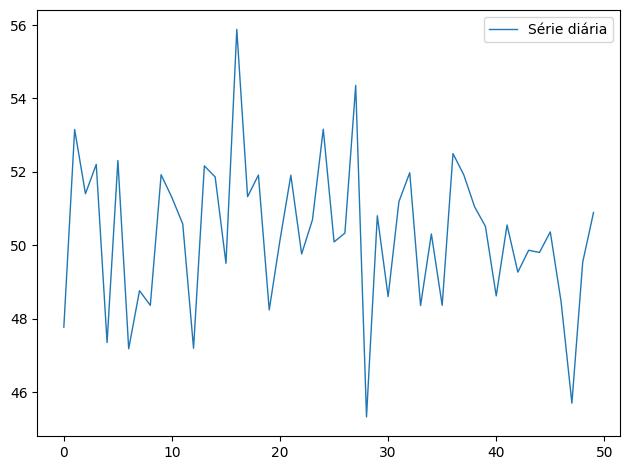

In [ ]:
fig, ax = plt.subplots()

tspplot(dados,label='Série diária',ax=ax)
tspdisplay('serie.tail()')

Note que, aparentemente, a série não apresenta tendências nem comportamentos sazonais e que seus valores variam em torno de 50 conforme esperado na simulação. Vamos suavizar a série por meio de médias ponderadas para fazer previsões da seguinte forma: 

<center> $\hat{y}_{t+1}= 0.7y_{t}+0.7(1-0.7)y_{t-1}+0.7(1-0.7)^2 y_{t-2}+...$ </center>

em que $\hat{y}_{t+1}$ representa o valor previsto da série um passo à frente. Note que, segundo a expressão acima, o valor previsto para o dia 51 será uma média ponderada dos valores observados cujos pesos diminuem (exponencialmente) conforme as observações se afastam. O peso de suavização selecionado neste exemplo foi de 0.7, porém, pode-se selecionar qualquer valor entre 0 e 1. O valor previsto para o dia 51 (valor não observado) é dado por:

$$\hat{y}_{51}=0.7(50.8929)+0.21(49.53969)+0.063(45.7004)+...$$

Você pode notar que para calcular a previsão de $y_{51}$, o valor mais recente ($y_{50}=50.8929$) tem um peso de 0.7, já o valor observado antes de ontem ($y_{49}=49.53969)$ tem um peso de 0.21, isto é, conforme as observações se afastam no tempo o peso atribuido a elas diminui. No seguinte código vamos calcular o valor previsto para o dia 51.


In [ ]:
y_51=[]
for i in list(range(0,50)):
  y_51.append(0.7*((1-0.7)**i)*dados[49-i])
y51=sum(y_51)

print("Valor previsto para o dia 51:",y51)

Valor previsto para o dia 51: 50.23000701233582


Vamos agora calcular todos os valores suavizados da série para visualizar o comportamento dessas duas séries (da série observada e da série suavizada). 

$$\hat{y}_{t+1}= 0.7y_{t}+0.7(1-0.7)y_{t-1}+0.7(1-0.7)^2 y_{t-2}+...$$

Aqui vamos assumir aqui que o valor suavizado para $y_1$ (isto é, quando $t=0$) é a média de todos os valores observados. Mais à frente, você verá que há outras opções para definir esse primeiro valor, mas a média é sempre um valor intuitivo para fazer previsões de séries estacionárias. Note o seguinte,

$$\hat{y}_1=50.2967= 0.7y_0$$

em que $50.2967$ é a média de $y_t$. Logo, $y_0=71.8524.$ A partir destes dois valores iniciais, você pode calcular os valores suavizados para toda a série.

$$\hat{y}_2= 0.7 y_1+ 0.7(1-0.7)y_0 = 48.5277.$$

Note que podemos calcular também $\hat{y}_2$ da seguinte forma

$$\hat{y}_2= 0.7 y_1+(1-0.7)\hat{y}_1 = 48.5277.$$

Podemos generalizar de tal forma que os valores suavizados da série podem ser calculados assim:

$$\hat{y}_{t+1}= 0.7y_{t}+(1-0.7)\hat{y}_{t}$$

Na figura a seguir, apresentam-se os valores da série (valores observados), os valores suavizados (linha tracejada) e o valor previsto para o dia 51 usando o peso de 0,7. Mostra-se também os valores suavizados usando um peso de 0,1.

In [ ]:
#@markdown outros alphas

y1_0=np.mean(dados)
y0_0=y1_0/0.1
s_0=[y0_0,y1_0]

for i in list(range(0,49)):
  s_0.append(0.1*dados[i]+(1-0.1)*s_0[i+1])
del s_0[0]

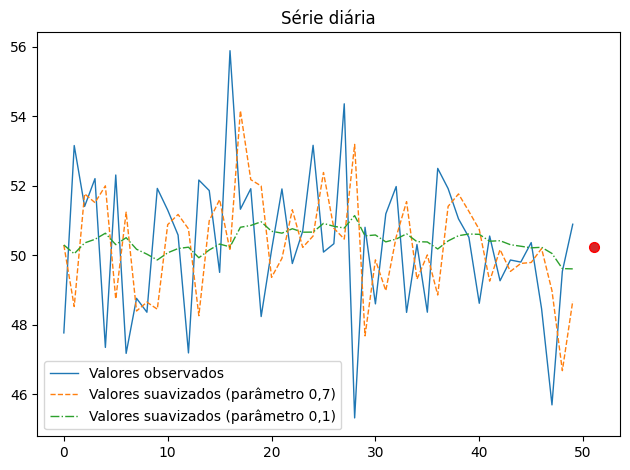

In [ ]:
y1=np.mean(dados)
y0=y1/0.7
s=[y0,y1]

for i in list(range(0,49)):
  s.append(0.7*dados[i]+(1-0.7)*s[i+1])
del s[0]

fig, ax = plt.subplots()

tspplot(serie["Valores observados"],label='Valores observados',ax=ax)
tspplot(s,title='Série diária',label='Valores suavizados (parâmetro 0,7)',linestyle='dashed',ax=ax,alpha=0.5)
tspplot(s_0,title='Série diária',label='Valores suavizados (parâmetro 0,1)',linestyle='dashdot',ax=ax,alpha=0.5)
plt.plot([51],[y51], marker="o", markersize=7, markeredgecolor="red")
plt.show()

Os modelos de suavização surgem para aprimorar o modelo mais ingênuo (ou naive), no qual as previsões são dadas por
$$\hat{y}_{t+1}=y_{t},$$
isto é, a previsão um passo à frente é simplesmente o último valor observado na série $y_t$. Você deve concordar que, na maioria dos casos, é mais interessante calcular uma média ponderada dos valores observados da série para prever seus valores conforme foi apresentado até aqui.

Por fim, você vai estudar outros modelos de suavização exponencial em que, na estrutura das médias ponderadas, são adicionados termos que consideram comportamentos sazonais e/ou tendência. Imagine que estamos tentando prever o volume de vendas de uma loja de varejo em um certo sábado usando o histórico de vendas dos últimos meses. Aqui também podemos considerar que as vendas registradas mais recentes podem fornecer mais informação para a previsão. No entanto, também podemos considerar que as vendas registradas no último sábado (faz 7 dias) devem ter um peso maior do que, por exemplo, aquelas registradas na quinta-feira (faz 2 dias), uma vez que nesse tipo de comércio são esperados comportamentos sazonais. Essa será a ideia utilizada para generalizar os modelos de suavização exponencial.

A escolha do método de Suavização Exponencial (em inglês, *Exponential smoothing*) baseia-se, principalmente, na identificação dos componentes (tendência e/ou sazonalidade) da série temporal a ser modelada e na forma como estes (componentes) devem ser modelados. Por exemplo, no caso de séries com comportamentos sazonais, deve-se identificar se o componente é aditivo ou multiplicativo, conceitos que vamos discutir ao longo do capítulo.

Neste capítulo, vamos estudar, principalmente, três modelos de SE:

1. Modelo exponencial simples para séries estacionárias.
2. Modelo exponencial Holt para séries com tendência
3. Modelo exponencial de Holt-Winters para séries com componente sazonal e/ou tendência.

Na prática, durante a modelagem da série temporal, você pode propor um conjunto de modelos e selecionar, por algum critério, o modelo que melhor explica o comportamento da variável de interesse. O critério de informação Akaike, AIC, amplamente utilizando na literatura, é baseado no conceito de selecionar o modelo mais parcimonioso, isto é, com o menor número de parâmetros, e que minimize a perda de informação decorrente da modelagem.  Assim, dado uma coleção de modelos candidatos para os dados, o modelo com menor AIC é o mais simples que explica bem o fenômeno de estudo e minimiza a informação perdida quando um modelo é usado para descrever o comportamento dos dados.

Você vai aprender a implementar modelos de suavização exponencial para fazer previsões de séries com comportamentos semelhantes aos apresentados nas quatro séries abaixo.

In [ ]:
dados = [] ; dados1 = [] ; dados2 = [] ; dados3 = [] 

t=list(range(0,100))
random.seed(100)    
for i in range(100): 
    temp = random.normalvariate(mu=100, sigma=2)
    dados.append(temp)
    dados1.append(temp+0.2*t[i])
    dados2.append(temp+0.2*t[i]+ 5*np.sin(2*np.pi*t[i]/21))
    dados3.append(temp+2*t[i]+ 0.7*t[i]*np.sin(2*np.pi*t[i]/7))


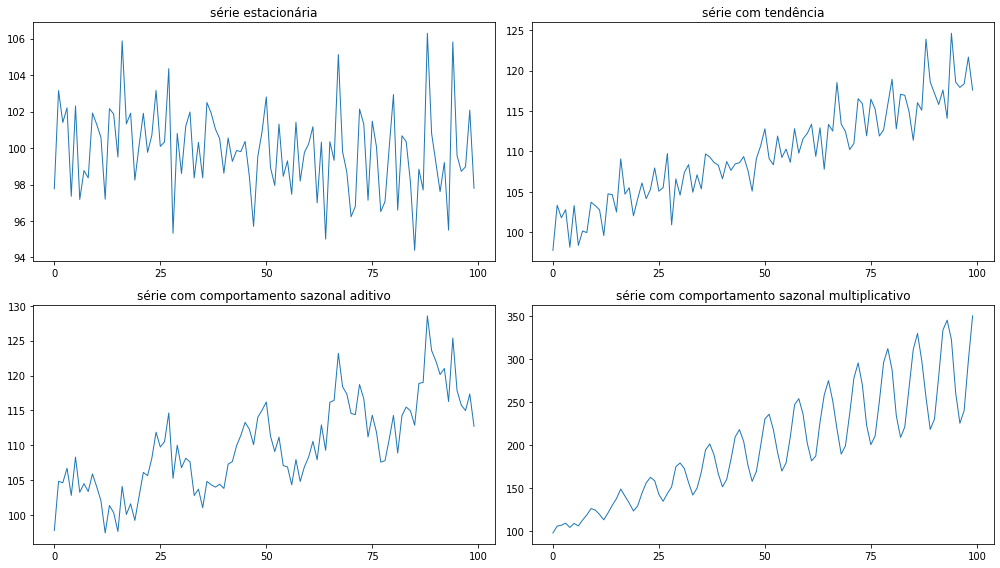

In [ ]:
#@markdown  
fig, ax = plt.subplots(2,2,figsize=(14,8))

show_files = [dados, dados1, dados2, dados3]
titles=["série estacionária","série com tendência","série com comportamento sazonal aditivo","série com comportamento sazonal multiplicativo"]

for i, axis in enumerate(fig.axes):
  tspplot(show_files[i],title=titles[i],ax=axis,nr_xticks=5)

Séries estacionárias e séries com tendências e/ou comportamentos sazonais.

## **Modelo 1. Suavização exponencial simples**

O modelo de **Suavização Exponencial simples** (em inglês, Simple exponential smoothing) é adequado para modelar séries temporais estacionárias, isto é, observações sem tendências ou comportamentos sazonais. Na estrutura deste modelo, os pesos atribuídos às observações diminuem (ou aumentam) exponencialmente conforme as observações se afastam ao longo do tempo. Seja $Y_t$ o valor da série no instante $t$, temos

$$\hat{Y}_{t+1}= \alpha Y_{t}+ \alpha(1-\alpha)Y_{t-1}+\alpha(1-\alpha)^2Y_{t-2}+...,$$

em que $0\leq \alpha \leq 1$ é o parâmetro de suavização que deverá ser estimado e que determina os pesos que serão atribuídos às observações. Você pode reparar que para valores de $\alpha$ próximos de um as observações recentes terão maiores pesos, já quando $\alpha$ for próximo de zero as observações mais distântes terão pesos maiores. Por fim, note que quando $\alpha=1$ as previsões serão iguais ao último valor observado da série, isto é, teremos um modelo ingênuo (ou naive) comentado anteriormente.

Vimos que para calcular os valores suavizados da série e fazer previsões é necessário estimar ou definir dois valores: o parâmetro de suavização $\alpha$ e o valor inicial $Y_0$. Estes valores podem ser calculados (estimados) minimizando a soma dos quadrados dos resíduos definidos como:

$$SQ=\sum_{t=1}^{T} (Y_t - \hat{Y}_t)^2$$

em que $Y_t$ e $\hat{Y}_t$ são, respectivamente, os valores observados e suavizados para o instante $t$. A ideia principal deste método de estimação consiste em encontrar os valores de $\alpha$ e $Y_0$, implementados no cálculo de  $\hat{Y}_t$ definido em 2.1, que minimizam a soma dos quadrados dos resíduos. Você poderá minimizar a SQ usando o módulo *Exponential Smoothing* da biblioteca *statsmodels* de python para encontrar os valores de $\alpha$ e $Y_0$.  Na prática, em alguns casos, estes valores podem ser escolhidos *a priori* pelo pesquisador com base na sua experiência.



**Vamos fazer previsões**. Pense que foram observados $T$ valores de $Y_t$, isto é, registram-se as observações de $Y_t$ para $t=1,2,...T$ e que desejamos fazer previsões para os instantes $T+1, T+2,...$. Para isto, você pode usar a expressão 2.1 que pode ser reescrita da seguinte forma:

$$\hat{y}_{t+1}= \alpha y_{t}+(1-\alpha)\hat{y}_{t}$$

Note que quando substituímos $t$ por $T$ para obter a previsão da série no instante $T+1$ temos:

$$\hat{y}_{T+1}= \alpha y_{T}+(1-\alpha)\hat{y}_{T}$$

Assim, a previsão será dada por uma média ponderada em que o valor observado no instante imediatamente anterior $y_T$ terá um peso de $\alpha$ e seu valor suavizado $\hat{y}_T$ um peso de $(1-\alpha)$. Agora, se desejamos fazer a previsão para o instante $T+2$ temos que

$$\hat{y}_{T+2}= \alpha y_{T+1}+(1-\alpha)\hat{y}_{T+1}$$

Repare que não temos o valor $y_{T+1}$, pois a série foi observada até o instante $T$. O que podemos fazer? Você pode, por exemplo, substituir $y_{T+1}$ pelo seu valor previsto. Neste caso teremos:

$$\hat{y}_{T+2}= \alpha \hat{y}_{T+1}+(1-\alpha)\hat{y}_{T+1}=\hat{y}_{T+1}.$$

Exato, no modelo de SE simples as previsões são “fat” uma vez que todas as previsões assumem o valor obtido na última suavização (previsão um passo à frente, instante $T+1$). Assim, você deve ter reparado que essas previsões serão adequadas se a série temporal analisada é estacionária.

Vamos usar uma representação alternativa deste modelo, na forma de componentes, para visualizar mais fácil as diferentes estruturas dos próximos modelos de Suavização Exponencial. No caso do modelo de Suavização Exponencial simples, a sua estrutura é dada por:


Equação de previsão: $\hat{Y}_{T+h}= l_T,  \ h=1,2,...$

Equação de nível: $l_T= \alpha Y_T + (1-\alpha)l_{T-1}$

Note que as previsões $h$ passos à frente de $Y_T$ são dadas pela equação de nível (level, em inglês) em que $Y_T$ representa o último valor observado da série. Você vai ver que nos próximos modelos de suavização exponencial serão incorporadas outras equações na estrutura do modelo para considerar, por exemplo, componentes de tendência e sazonalidade.

No seguinte exemplo, vamos estudar como usar a biblioteca *statsmodels/Exponential Smoothing* de python.


### Exemplo 1

Vamos ajustar a série mensal: Produção Física Industrial de Abate e fabricação de produtos de carne do Brasil no período de janeiro de 2018 a dezembro de 2022. Disponível em https://sidra.ibge.gov.br/tabela/7511. 

In [ ]:
# Importando a série temporal
df1=pd.read_csv(path+'Producao.csv', delimiter=';', decimal=",")
df1.index=pd.date_range(start='1/2018', end='07/2022', freq='M')
df1.head()

,mês,ano,valor
2018-01-31,janeiro,2018.0,101.26
2018-02-28,fevereiro,2018.0,89.11
2018-03-31,março,2018.0,99.17
2018-04-30,abril,2018.0,98.00
2018-05-31,maio,2018.0,84.99


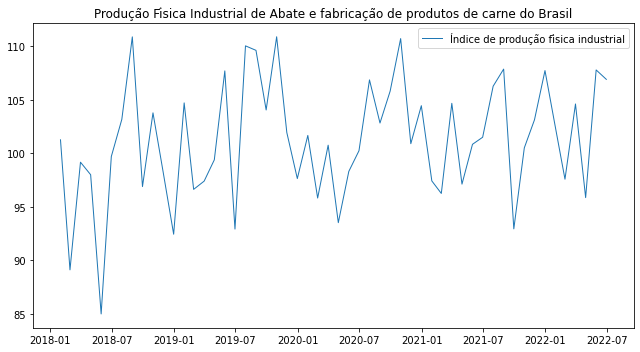

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(9,5))
tspplot(df1.valor,title='Produção Física Industrial de Abate e fabricação de produtos de carne do Brasil',label='Índice de produção física industrial',ax=ax)
#plt.ylabel("Índice de produção física industrial")

Observa-se que o índice de produção aparentemente não apresenta tendências nem comportamentos sazonais, seus valores variam entre 84,99 e 110,89 unidades. O índice médio no período estudado é de 101.18 unidades. Maiores detalhes do índice podem ser encontrados no site do IBGE, pois neste capítulo estaremos interessados apenas na modelagem da série. 

In [ ]:
Ajuste=SimpleExpSmoothing(df1.valor, initialization_method="estimated").fit(optimized=True)
print(Ajuste.summary())

                       SimpleExpSmoothing Model Results                       
Dep. Variable:                  valor   No. Observations:                   54
Model:             SimpleExpSmoothing   SSE                           1698.273
Optimized:                       True   AIC                            190.213
Trend:                           None   BIC                            194.191
Seasonal:                        None   AICC                           191.029
Seasonal Periods:                None   Date:                 Mon, 06 Mar 2023
Box-Cox:                        False   Time:                         00:52:44
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level           1.4901e-08                alpha                 True
initial_level              101.18222                

Você pode observar que o valor estimado de $\alpha$ é 1.4901e-08, muito pequeno, indicando que os valores suavizados serão muito parecidos com o valor incial $Z_0$, uma vez que os valores mais distantes apresentam maiores pesos. Por fim, o valor estimado de $Z_0$ foi de 101,18.

Usando o método de inicialização "estimated", os valores de $\alpha$ e $Z_0$ são estimados usando o algortimo L-BFGS-B (default) para minimizar a soma de quadrados dos resíduos. Pode-se selecionar o método de mínimos quadrados adicionando na função fit method="ls". Vale enfatizar que, dependendo do método que você selecione, o tempo de minimização pode aumentar. 

In [ ]:
# Previsões 

print(Ajuste.forecast(5))

2022-07-31    101.18222
2022-08-31    101.18222
2022-09-30    101.18222
2022-10-31    101.18222
2022-11-30    101.18222
Freq: M, dtype: float64


Note que as previsões são "flat", isto é, os próximos 5 valores previstos da série são os mesmos. A seguir, como exercício, vamos analisar o comportamento das previsões e o ajuste do modelo de SE simples quando considerados diferentes valores de $\alpha$ (não só o valor que minimiza a soma dos resíduos ao quadrado) 

In [ ]:
fit1=SimpleExpSmoothing(df1.valor, initialization_method="estimated").fit(optimized=True)
fit2 = SimpleExpSmoothing(df1.valor, initialization_method="heuristic").fit(smoothing_level=0.4)
fit3 = SimpleExpSmoothing(df1.valor, initialization_method="heuristic").fit(smoothing_level=0.8)

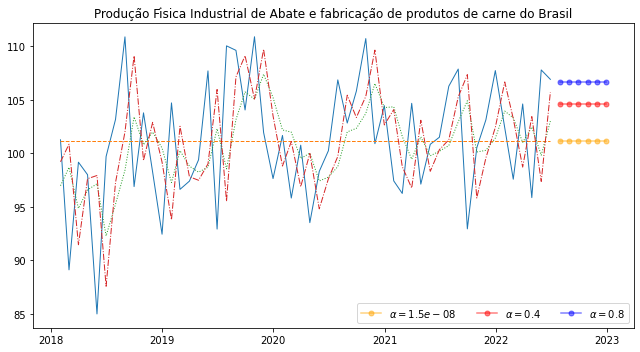

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

tspplot(df1.valor,ax=ax,title='Produção Física Industrial de Abate e fabricação de produtos de carne do Brasil')
tspplot(fit1.fittedvalues,linestyle="dashed",ax=ax)
tspplot(fit2.fittedvalues,linestyle="dotted",ax=ax)
tspplot(fit3.fittedvalues, linestyle="dashdot",ax=ax)

fcast1 = fit1.forecast(6)
fcast2 = fit2.forecast(6)
fcast3 = fit3.forecast(6)

(line1,) = plt.plot(fcast1, marker="o", color="orange",alpha=0.5,markersize=5)
(line2,) = plt.plot(fcast2, marker="o", color="red",alpha=0.5,markersize=5)
(line3,) = plt.plot(fcast3, marker="o", color="blue",alpha=0.5,markersize=5)

plt.legend([line1, line2, line3],
           [r"$\alpha=%s$" % round(fit1.model.params["smoothing_level"],9), r"$\alpha=0.4$", r"$\alpha=0.8$"],
           ncol=3, loc="lower right")
plt.show()

Note que, independentemente do valor de $\alpha$, as previsões sempre são "flat". Para valores altos de $\alpha$, observa-se que as previsões são próximas do último valor observado. Já para valores de $\alpha$ próximos de zero, o valor previsto é próximo do valor médio da série. 

Finalmente, observe que o menor valor de AIC é atingido quando é utilizado o valor estimado de $\alpha$ minimizando a soma de quadrados dos resíduos.

In [ ]:
print("AIC dos modelos ajustados")
print("Modelo 1 (\u03B1 =", round(fit1.model.params["smoothing_level"],9),"):", round(fit1.aic,4))
print("Modelo 2 (\u03B1 =", 0.4,"):", round(fit2.aic,4))
print("Modelo 3 (\u03B1 =", 0.8,"):", round(fit3.aic,4))

AIC dos modelos ajustados
Modelo 1 (α = 1.5e-08 ): 190.2127
Modelo 2 (α = 0.4 ): 199.3411
Modelo 3 (α = 0.8 ): 213.9667


## **Modelo 2. Suavização Exponencial linear de Holt**

Se você deseja fazer previsões para uma série que apresenta tendência crescente, você deve concordar que fazer uma média ponderada das observações registradas até um instante $T$ sem considerar a taxa de crescimento não é uma boa ideia. Assim, para fazer previsões de séries temporais com tendência, o modelo de suavização exponencial simples foi generalizado por Holt (1957). Neste modelo, consideram-se dois componentes na sua estrutura: Nível e Tendência.

$$ \text{Equação de previsão:} \hat{Y}_{T+h}= l_T + h b_T, h=1,2,...$$

em que $l_T$ e $b_T$ representam, respectivamente, as equações de nível e de tendência que dependem de dois parâmetros $\alpha$ e $\beta$. Neste capítulo, estaremos interessados na aplicação dos modelos de suavização exponencial, assim, para maiores detalhes do desenvolvimento matemático das equações $l_T$ e $b_T$, recomenda-se ver Hyndman, R. J., and Athanasopoulos, G. (2018).


Neste modelo, as previsões $h$ passos à frente, $\hat{Y}_{T+h}$, são uma função linear de $h$ definida pela soma de $l_T$ (nível da série no instante $T$) e $h$ vezes $b_T$ (tendência no intante $T$). Para analisar a saída do ajuste deste modelo em python, você deve ficar atento que valores de $\alpha$ próximos de 1 indicam que o nível da série se altera fortemente a cada nova observação e valores de $\beta$ próximos de zero indicam que a inclinação da série dificilmente muda ao longo do tempo. Por fim, ressalta-se que os parâmetros $\alpha$ e $\beta$ assumem valores entre zero e um.

 

### Exemplo 2

Vamos ajustar a série trimestral: PIB a preços de mercado - Valores Correntes (Bilhões de Reais) do primeiro trimestre de 2005 ao terceiro trimestre de 2022, disponível em https://www.ibge.gov.br/estatisticas/economicas/industria/9300-contas-nacionais-trimestrais.html?=&t=series-historicas

In [ ]:
# Série temporal
df2=pd.read_csv(path+'PIB.csv', delimiter=';', decimal=",")
df2.index=pd.date_range(start='1/2010', end='8/2022', freq='3M')

,trimestre,ano,valor
2010-01-31,1,2010,886.40
2010-04-30,2,2010,944.15
2010-07-31,3,2010,997.94
2010-10-31,4,2010,1057.37
2011-01-31,1,2011,1016.53


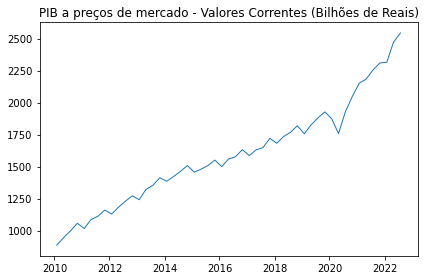

In [ ]:
fig, ax = plt.subplots()

tspplot(df2.valor,title='PIB a preços de mercado - Valores Correntes (Bilhões de Reais)',lw=1,ax=ax)
tspdisplay('df2')

Nota-se uma tendência crescente no PIB a preços de mercado no período de estudo. Salienta-se a queda durante o segundo trimestre de 2020 decorrente, provavelmente, dos impactos do COVID-19. No entanto, observa-se que nos próximos trimestres voltou a tendência crescente na série.

In [ ]:
Ajuste2 = ExponentialSmoothing(df2.valor,trend="additive",initialization_method="estimated").fit()
print(Ajuste2.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    valor   No. Observations:                   51
Model:             ExponentialSmoothing   SSE                         145538.945
Optimized:                         True   AIC                            413.775
Trend:                         Additive   BIC                            421.502
Seasonal:                          None   AICC                           415.684
Seasonal Periods:                  None   Date:                 Mon, 06 Mar 2023
Box-Cox:                          False   Time:                         00:56:08
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8490406                alpha                 True
smoothing_trend            0.00100

Neste ajuste, consideramos uma tendência aditiva. O valor estimado de $\alpha$ é 0,84, um valor alto (próximo de 1) indicando que o nível da série se altera a cada valor observado. O valor do parâmetro de suavização da equação de tendência $\beta$ foi de 0.0011. Se você deseja ajustar uma tendência multiplicativa, é suficiente trocar "additive" por "multiplicative" na função trend. Lembre que uma tendência aditiva indica que há uma tendência linear nos dados, ao passo que uma multiplicativa indica uma tendência não linear.

Usando o método de inicialização "estimated", os valores de $\alpha$, $\beta$ e os valores iniciais serão estimados usando o algortimo L-BFGS-B (default) para minimizar a soma de quadrados dos resíduos.  

In [ ]:
print(Ajuste2.forecast(5))

2022-10-31    2567.148111
2023-01-31    2599.817290
2023-04-30    2632.486468
2023-07-31    2665.155647
2023-10-31    2697.824825
Freq: 3M, dtype: float64


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


Você observa que os valores previstos acompanham a tendência crescente, apresentando um aumento trimestral relativo de aproximadamente 1,272%. A seguir, como exercício, você pode ver o comportamento das previsões quando considerados outros valores dos parâmetros de suavização $\alpha$ e $\beta$.

In [ ]:
fit1=ExponentialSmoothing(df2.valor,trend="additive",initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(df2.valor,trend="additive", initialization_method="estimated").fit(smoothing_level=0, smoothing_trend=1, optimized=False)
fit3 = ExponentialSmoothing(df2.valor,trend="additive", initialization_method="heuristic").fit(smoothing_level=0.1, smoothing_trend=0.8, optimized=False)

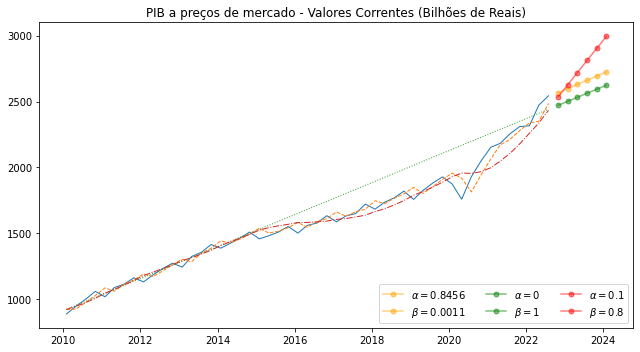

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

tspplot(df2.valor,ax=ax,title='PIB a preços de mercado - Valores Correntes (Bilhões de Reais)')
tspplot(fit1.fittedvalues,linestyle="dashed",ax=ax)
tspplot(fit2.fittedvalues,linestyle="dotted",ax=ax)
tspplot(fit3.fittedvalues, linestyle="dashdot",ax=ax)

fcast1 = fit1.forecast(6)
fcast2 = fit2.forecast(6)
fcast3 = fit3.forecast(6)

(line1,) = plt.plot(fcast1, marker="o", color="orange",alpha=0.5,markersize=5)
(line2,) = plt.plot(fcast2, marker="o", color="green",alpha=0.5,markersize=5)
(line3,) = plt.plot(fcast3, marker="o", color="red",alpha=0.5,markersize=5)

plt.legend([line1, line1, line2,line2,line3, line3],
           [r"$\alpha=%s$" % round(fit1.model.params["smoothing_level"],4), r"$\beta=%s$" %round(fit1.model.params["smoothing_trend"],4),
            r"$\alpha=0$",r"$\beta=1$", r"$\alpha=0.1$",r"$\beta=0.8$"],
           ncol=3, loc="lower right")
plt.show()

Para $\alpha=0$ e $\beta=1$, note que as observações não são suavizadas e o modelo considera somente a tendência na série. Por isso, os valores ajustados são de uma reta. Finalmente, perceba que, quando consideramos valores de $\alpha$ próximos de zero e de $\beta$ próximos de um (cenário contrário ao estimado), os valores previstos seguem uma tendência linear com coeficiente angular maior quando comparados com os valores previstos usando um modelo de SE com os valores estimados quando minimizada a soma de quadrados.

A seguir, você pode comparar o ajuste e as previsões quando consideradas as tendência aditivas e multiplicativas. 


In [ ]:
fit1=ExponentialSmoothing(df2.valor,trend="additive",initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(df2.valor,trend="multiplicative", initialization_method="estimated").fit()


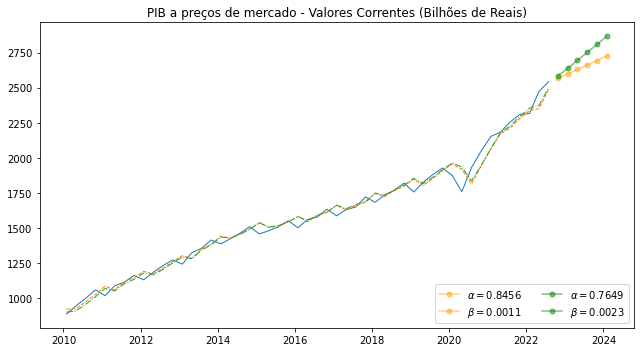

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

tspplot(df2.valor,ax=ax,title='PIB a preços de mercado - Valores Correntes (Bilhões de Reais)')
tspplot(fit1.fittedvalues,linestyle="dashed",ax=ax)
tspplot(fit2.fittedvalues,linestyle="dashdot",ax=ax,alpha=1)

fcast1 = fit1.forecast(6)
fcast2 = fit2.forecast(6)

(line1,) = plt.plot(fcast1, marker="o", color="orange",alpha=0.5,markersize=5)
(line2,) = plt.plot(fcast2, marker="o", color="green",alpha=0.5,markersize=5)

plt.legend([line1, line1, line2,line2,line3, line3],
           [r"$\alpha=%s$" % round(fit1.model.params["smoothing_level"],4), r"$\beta=%s$" %round(fit1.model.params["smoothing_trend"],4),
            r"$\alpha=%s$" % round(fit2.model.params["smoothing_level"],4), r"$\beta=%s$" %round(fit2.model.params["smoothing_trend"],4)],
           ncol=2, loc="lower right")
plt.show()

Quando considerada a tendência multiplicativa, o parâmetro de suavização da tendência aumenta, fornecendo um modelo com uma maior inclinação.

## **Modelo 3.  Suavização Exponencial sazonal de Holt-Holt-Winters**


Finalmente, o modelo de SE de Holt foi generalizado por Holt (1957) e Winters (1960) para fazer previsões de séries temporais com comportamentos sazonais. O modelo sazonal de Holt-Winters considera três componentes na sua estrutura: Nível, Tendência e Sazonalidade. 

A ideia principal deste modelo consiste em incorporar valores defasados da série que contribuam na previsão de dados com padrões que se repetem de tempos em tempos, em intervalos específicos. Imagine que desejamos prever as vendas de uma loja, cujos registros indicam que nos fins de semana as vendas sempre aumentam em relação aos dias úteis. Aqui, você deve concordar que, se queremos prever as vendas no próximo sábado, a estrutura do modelo deve considerar o histórico das vendas registradas nos últimos sábados, assim como a tendência deve ser observada nas vendas, uma vez que podemos ter um comportamento crescente/decrescente ou estável. 

Por fim, você deve ficar atento que neste modelo existem duas variações na estrutura do componente sazonal, o aditivo e o multiplicativo. No momento da escolha você pode considerar que, se o componente sazonal varia com a tendência, recomenda-se implementar o componente multiplicativo, já quando o componente sazonal não depende de outras componentes, o aditivo é recomendado.

### **Holt-Winters’ additive method**

A estrutura do modelo sazonal para o componente aditivo é dada por:

$$ \text{Equação de previsão:} \hat{Y}_{T+h}= l_T + h b_T +s_{T+h-m(k+1)}$$

em que $l_T$, $b_T$ e $S_T$ representam, respectivamente, as equações de nível, tendência e de sazonalidade que dependem de parâmetros $\alpha$, $\beta$ e $\gamma$. Na equação de sazonalidade, $k$ é a parte inteira de $(h−1)/m$, isto garante que as estimativas dos índices sazonais usados para as previsões sejam provenientes do último período da amostra, sendo $m$ o período sazonal da série. 

Na estrutura da equação de sazonalidade, $S_t$, calcula-se uma média ponderada entre o índice sazonal atual e o índice sazonal de um período anterior, cujo peso depende de um parâmetro a ser estimado $\gamma$. Para maiores detalhes do desenvolvemento matemático da estrutura deste modelo, ver Hyndman, R. J., and Athanasopoulos, G. (2018).


### Exemplo

Vamos ajustar a série mensal: Volume de vendas no comércio varejista no estado de São Paulo no período de janeiro de 2005 a dezembro de 2014. Disponível: https://www.ibge.gov.br/estatisticas/economicas/comercio/9227-pesquisa-mensal-de-comercio.html?=&t=series-historicas

In [ ]:
# Série temporal
df3=pd.read_csv(path+'Volume_de_vendas.csv', delimiter=';', decimal=",")
df3.index=pd.date_range(start='1/2005', end='1/2015', freq='M')

,mês,ano,valor
2005-01-31,janeiro,2005,47.73022
2005-02-28,fevereiro,2005,43.32036
2005-03-31,março,2005,49.71898
2005-04-30,abril,2005,48.42196
2005-05-31,maio,2005,50.49719


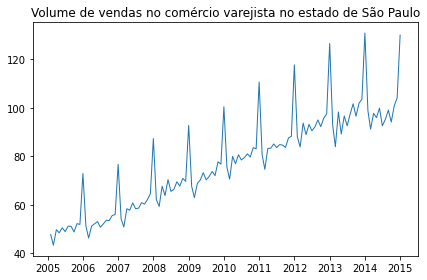

In [ ]:
fig, ax = plt.subplots()

tspplot(df3.valor,title='Volume de vendas no comércio varejista no estado de São Paulo',lw=1,ax=ax)
tspdisplay('df3')

Você deve ter percebido que o volume de vendas no comércio varejista em São Paulo, no período de estudo, apresenta uma tendência crescente e um comportamento sazonal que se repete a cada ano. O maior volume de vendas é sempre observado no mês de dezembro e o menor no mês de fevereiro.

A seguir, apresenta-se um gráfico boxplot das vendas agrupadas por mês. Destaca-se que o volume mediano de vendas no mês de dezembro é superior quando comparado com os volumes máximos vendidos em qualquer outro mês no período analisado.

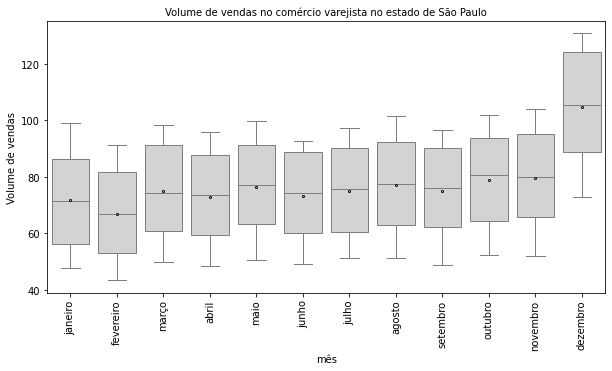

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,5))

sns.boxplot(x="mês", y="valor", data=df3,color="lightgrey", linewidth=1.0, width=0.8,showmeans=True,
                        meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"2"})
plt.title("Volume de vendas no comércio varejista no estado de São Paulo", fontsize=10)
plt.ylabel("Volume de vendas", fontsize=10)
plt.xticks(rotation=90) 
plt.show()

Pelo gráfico das vendas, você perceberá que o comportamento sazonal, aparentemente, não aumenta com a tendência da série. Assim, um modelo de suavização exponencial considerando tendência e sazonalidade aditiva  com período de 12 meses foi ajustado. Os parâmetros de suavização e valores iniciais foram estimados minimizando a soma de quadrados dos resíduos.

In [ ]:
Ajuste3 = ExponentialSmoothing(df3.valor,trend="additive",seasonal="multiplicative",seasonal_periods=12,initialization_method="estimated").fit()
print(Ajuste3.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    valor   No. Observations:                  120
Model:             ExponentialSmoothing   SSE                            345.897
Optimized:                         True   AIC                            159.038
Trend:                         Additive   BIC                            203.638
Seasonal:                Multiplicative   AICC                           165.810
Seasonal Periods:                    12   Date:                 Mon, 06 Mar 2023
Box-Cox:                          False   Time:                         00:58:22
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4481628                alpha                 True
smoothing_trend          

Os coeficientes estimados para os meses de dezembro (1,305) e fevereiro (0,866) são, respectivamente, o maior e menor valor estimado dos coeficientes sazonais, resultado esperado após a análise descritiva. Os valores previstos para o mês de 2015 são calculados a seguir

In [ ]:
print(Ajuste3.forecast(12))

2015-01-31     97.988643
2015-02-28     90.408879
2015-03-31    100.845551
2015-04-30     97.252734
2015-05-31    102.625548
2015-06-30     98.161835
2015-07-31    101.230180
2015-08-31    104.225100
2015-09-30    100.144141
2015-10-31    105.834706
2015-11-30    106.981472
2015-12-31    138.135398
Freq: M, dtype: float64


Vamos considerar três novos modelos, alterando o tipo de tendência (aditiva ou multiplicativa), para analisar as previsões. No último modelo, vamos alterar o período sazonal para 6 meses.

In [ ]:
fit1=ExponentialSmoothing(df3.valor,trend="additive",seasonal="additive",seasonal_periods=12,initialization_method="estimated").fit()
fit2=ExponentialSmoothing(df3.valor,trend="multiplicative",seasonal="additive",seasonal_periods=12,initialization_method="estimated").fit()
fit3=ExponentialSmoothing(df3.valor,trend="additive",seasonal="additive",seasonal_periods=6,initialization_method="estimated").fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


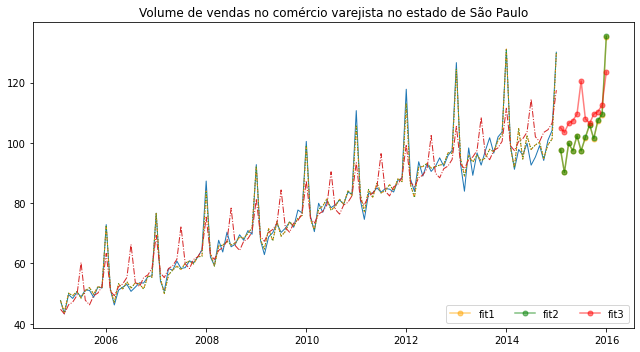

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

tspplot(df3.valor,ax=ax,title='Volume de vendas no comércio varejista no estado de São Paulo')
tspplot(fit1.fittedvalues,linestyle="dashed",ax=ax)
tspplot(fit2.fittedvalues,linestyle="dotted",ax=ax)
tspplot(fit3.fittedvalues, linestyle="dashdot",ax=ax)

fcast1 = fit1.forecast(12)
fcast2 = fit2.forecast(12)
fcast3 = fit3.forecast(12)

(line1,) = plt.plot(fcast1, marker="o", color="orange",alpha=0.5,markersize=5)
(line2,) = plt.plot(fcast2, marker="o", color="green",alpha=0.5,markersize=5)
(line3,) = plt.plot(fcast3, marker="o", color="red",alpha=0.5,markersize=5)

plt.legend([line1, line2, line3],
           ["fit1","fit2","fit3"],
           ncol=3, loc="lower right")
plt.show()

Você observará que, quando considerado um período sazonal de 6 meses, os valores ajustados e previstos não acompanham o comportamento da série. Isso é esperado, porque, na análise descritiva, o comportamento sazonal se repete para o período de um ano. Por fim, quando é considerada uma tendência multiplicativa, os valores previstos para o ano de 2015 são ligeiramente superiores aos obtidos quando considerada uma tendência aditiva.

In [ ]:
pd.DataFrame(data={'Previsões Modelo 1':fcast1, 'Previsões Modelo 2':fcast2})

,Previsões Modelo 1,Previsões Modelo 2
2015-01-31,97.628489,97.660392
2015-02-28,90.167506,90.216797
2015-03-31,99.792640,99.867127
2015-04-30,97.319915,97.412294
2015-05-31,102.268795,102.378612
2015-06-30,97.261836,97.395964
2015-07-31,101.670851,101.825787
2015-08-31,105.910797,106.076975
2015-09-30,101.261831,101.439239
2015-10-31,107.332460,107.521677


### **Holt-Winters’ multiplicative method**

A estrutura do modelo sazonal para o componente multiplicativo é dada por:

$$ \text{Equação de previsão: } \hat{Y}_{T+h}= (l_T + h b_T) \times s_{t+h-m(k+1)}$$

em que $l_T$, $b_T$ e $S_T$ representam, respectivamente, as equações de nível, tendência e de sazonalidade que dependem de parâmetros $\alpha$, $\beta$ e $\gamma$. Valores pequenos (próximos de zero) de $\gamma$ para o modelo multiplicativo indicam que o componente sazonal dificilmente muda ao longo do tempo.

### Exemplo

Vamos modelar a série mensal: Número total de passageiros de uma companhia aérea dos EUA no período de janeiro de 1949 a dezembro de 1960.

In [ ]:
# Série temporal

df4=pd.read_csv(path+"airline-passengers.csv")
df4.index=pd.date_range(start='1/1949', end='1/1961', freq='M')

,Month,Passengers
1949-01-31,1949-01,112
1949-02-28,1949-02,118
1949-03-31,1949-03,132
1949-04-30,1949-04,129
1949-05-31,1949-05,121


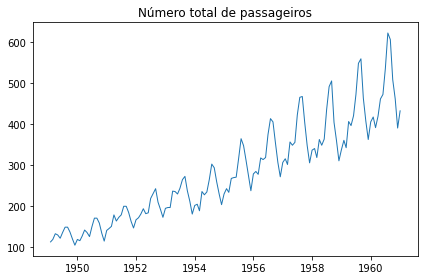

In [ ]:
fig, ax = plt.subplots()

tspplot(df4.Passengers,title='Número total de passageiros',lw=1,ax=ax)
tspdisplay('df4')

Observa-se que o número total de passageiros da companhia aérea em questão apresenta uma tendência crescente e um comportamento sazonal que se repete a cada ano, cuja amplitude aumenta conforme aumenta a tendência. Assim, recomenda-se usar um modelo de SE componente sazonal multiplicativo.

No gráfico de boxplot a seguir, apresenta-se o número de passageiros agrupados por mês. É notável que o maior número de passageiros é registrado no trimestre de junho a agosto, possivelmente relacionado com o período de férias e com o clima de verão no hemisfério norte.

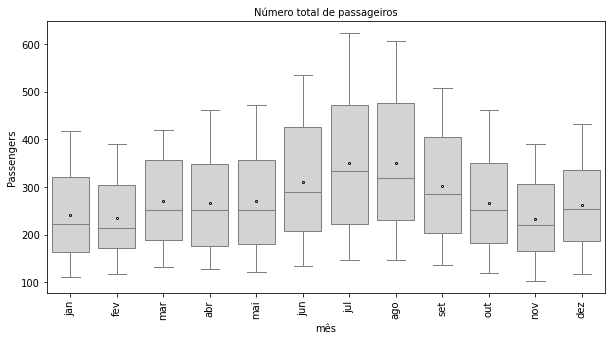

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,5))

df4["mês"]=["jan", "fev", "mar", "abr","mai","jun","jul","ago","set", "out", "nov","dez"]*12
sns.boxplot(x="mês", y="Passengers", data=df4,color="lightgrey", linewidth=1.0, width=0.8,showmeans=True,
                        meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"2"})
plt.title("Número total de passageiros", fontsize=10)
plt.xticks(rotation=90) 
plt.show()

Um modelo de Holt-Winters com componente sazonal multiplicativo e tendência aditiva foi ajustado. 

In [ ]:
Ajuste4 = ExponentialSmoothing(df4.Passengers,trend="additive",seasonal="multiplicative",seasonal_periods=12,initialization_method="estimated").fit()
print(Ajuste4.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:               Passengers   No. Observations:                  144
Model:             ExponentialSmoothing   SSE                          15952.880
Optimized:                         True   AIC                            709.892
Trend:                         Additive   BIC                            757.409
Seasonal:                Multiplicative   AICC                           715.364
Seasonal Periods:                    12   Date:                 Mon, 06 Mar 2023
Box-Cox:                          False   Time:                         01:00:31
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3185898                alpha                 True
smoothing_trend          

Você pode notar que os maiores coeficientes sazonais correspondem aos meses de junho, julho e agosto, conforme observado na análise descritiva. O parâmetro de suavização de nível e sazonalidade indicam que o nível da série muda a cada nova observação e que há um forte componente sazonal nos dados. 

Nos exemplos seguintes, apresentam-se os comportamentos das previsões alterando o tipo de tendência e sazonalidade (aditiva ou multiplicativa). Você verá que as previsões apresentam valores semelhantes.

In [ ]:
fit1=ExponentialSmoothing(df4.Passengers,trend="additive",seasonal="multiplicative",seasonal_periods=12,initialization_method="estimated").fit()
fit2=ExponentialSmoothing(df4.Passengers,trend="multiplicative",seasonal="additive",seasonal_periods=12,initialization_method="estimated").fit()
fit3=ExponentialSmoothing(df4.Passengers,trend="multiplicative",seasonal="multiplicative",seasonal_periods=12,initialization_method="estimated").fit()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


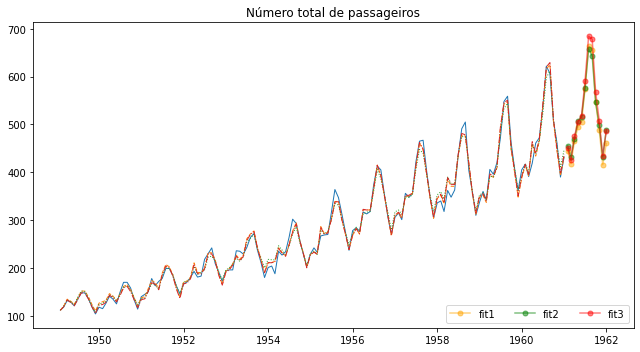

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))

tspplot(df4.Passengers,ax=ax,title='Número total de passageiros')
tspplot(fit1.fittedvalues,linestyle="dashed",ax=ax)
tspplot(fit2.fittedvalues,linestyle="dotted",ax=ax)
tspplot(fit3.fittedvalues, linestyle="dashdot",ax=ax)

fcast1 = fit1.forecast(12)
fcast2 = fit2.forecast(12)
fcast3 = fit3.forecast(12)

(line1,) = plt.plot(fcast1, marker="o", color="orange",alpha=0.5,markersize=5)
(line2,) = plt.plot(fcast2, marker="o", color="green",alpha=0.5,markersize=5)
(line3,) = plt.plot(fcast3, marker="o", color="red",alpha=0.5,markersize=5)

plt.legend([line1, line2, line3],
           ["fit1","fit2","fit3"],
           ncol=3, loc="lower right")
plt.show()

# Sumário

Os modelos de Suavização Exponencial podem ser implementados para fazer previsões de séries temporais por meio de médias ponderadas usando o histórico dos dados. Na estrutura destes modelos, podem-se incorporar termos que permitam modelar para dados com tendências e/ou componentes sazonais. Os pesos atribuídos nas médias ponderadas destes modelos diminuem (ou aumentam) de forma exponencial daí seu nome.




Neste capítulo, você vai estudar os modelos mais relevantes de Suavização Exponencial. A principal utilidade desses modelos é fazer previsões de séries temporais por meio de médias ponderadas usando o histórico da série, cujos pesos atribuídos diminuem, de forma exponencial, conforme as observações se afastam ao longo do tempo.

A seguir, encontram-se as principais funções que devem ser implementadas para a construção dos modelos de Suavização Exponencial usando a biblioteca statsmodel.

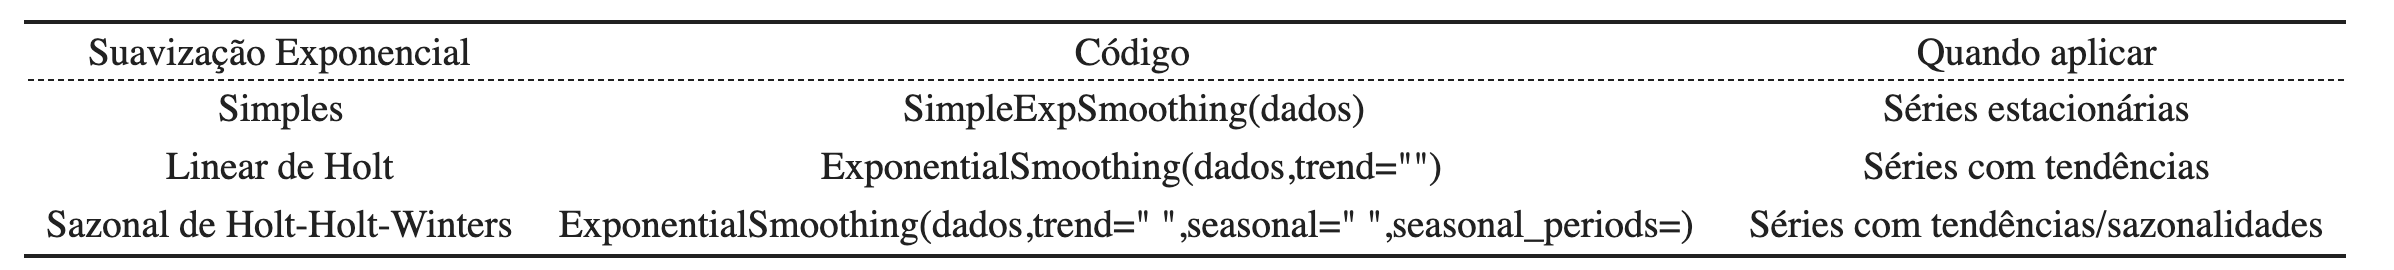

Quando usamos os modelos de Suavização Exponencial podemos considerar dois tipos de tendências e sazonalidades: aditivas e multiplicativas. Recomenda-se usar tendência aditiva quando há uma tendência linear nos dados e uma multiplicativa quando não é linear. Já no componente sazonal, você pode selecionar multiplicativo quando o componente sazonal varia com a tendência e aditivo quando o componente sazonal não depende da tendência.

Nos próximos capítulos vamos estudar outros modelos, entre eles, os modelos ARIMA que consideram o histórico dos dados usando na sua estrutura a dependência serial dos dados. Na prática, consideram-se várias classes de modelos para selecionar posteriormente aquele que produz, por exemplo, melhores previsões.

# Para Saber Mais

Para saber mais a biblioteca statsmodels/Suavização Exponencial ver a documentação oficial em

* https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

Os modelos Suavização Exponencial podem ser estudados desde um ponto de vista mais matemático nos livros:

* BROCKWELL, Peter J.; DAVIS, Richard A. (Ed.). Introduction to time series and forecasting. New York, NY: Springer New York, 2002.

*  HYNDMAN, Rob J.; ATHANASOPOULOS, George. Forecasting: principles and practice. OTexts, 2018. Disponível em: https://otexts.com/fpp3/